In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


data = pd.read_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Data\ventilator-pressure-prediction\test.csv")


data = data[data['R'] == 50]

data_train_full = data
data_train =data


In [67]:


## Data Engineering
## add additonal feature to catagorize input based on time step catagory.
## seems like there are two types of time step delta/increment for a given breath. One has average time step delta around 0.0340
## the other has time step delta/increment around 0.03215125

#Add time index and remove time_step, id and breath_id columns
data_train['time_index'] = (data_train_full['id']-1).mod(80)
data_train.drop(columns=['id'], inplace=True)

time_step_mean = data_train.groupby('breath_id')[['time_step']].mean().reset_index()
time_step_mean.rename(columns={'time_step':'time_step_catagory'}, inplace=True)
time_step_catagory_df = pd.merge(data_train, time_step_mean, on=['breath_id'])
time_step_catagory_df.loc[time_step_catagory_df['time_step_catagory'] >=1.3 , 'time_step_catagory'] = 1
time_step_catagory_df.loc[(time_step_catagory_df['time_step_catagory'] < 1.3) & (time_step_catagory_df['time_step_catagory'] > 1), 'time_step_catagory'] = 0

##Data Engineering: 
## add additional 80 features. Use time series as features. Because lung's pressure at any given time is affected by a series of u_in.
u_in_duplicates = data_train['u_in'].to_numpy()
tiled = np.tile(u_in_duplicates, (80,1)).transpose()
numberOfBreathIds = data_train_full['breath_id'].nunique()
x_reshaped = np.reshape(tiled, (numberOfBreathIds, 80, 80))
y = x_reshaped.transpose((0, 2, 1))
triangular = np.tril(y, 0)
row_count, column_count = data_train.shape
updated_data = np.reshape(triangular, (row_count,80))

numberOfAddedFeatures = 80
columnsNames = list(range(0, numberOfAddedFeatures))
new_feature_df = pd.DataFrame(updated_data, columns =columnsNames)
added_features_data = pd.concat([time_step_catagory_df, new_feature_df], axis=1)

#drop breath_id and time_step columns
print(added_features_data['breath_id'].nunique())
added_features_data.drop(columns=['breath_id'], inplace=True)
added_features_data.drop(columns=['time_step'], inplace=True)
added_features_data.drop(columns=['u_in'], inplace=True)




20085


In [8]:
import xgboost

xgb_reg = xgboost.XGBRegressor( learning_rate = 0.6, n_estimators = 200, tree_method = exact)
xgb_reg.fit(added_features_data, data_train_target, eval_set=[(added_features_data_test, data_test_target)], early_stopping_rounds=5)
y_pred = xgb_reg.predict(added_features_data)


[0]	validation_0-rmse:6.45119
[1]	validation_0-rmse:3.89719
[2]	validation_0-rmse:3.09875
[3]	validation_0-rmse:2.79268
[4]	validation_0-rmse:2.64728
[5]	validation_0-rmse:2.48957
[6]	validation_0-rmse:2.41282
[7]	validation_0-rmse:2.34313
[8]	validation_0-rmse:2.27783
[9]	validation_0-rmse:2.21412
[10]	validation_0-rmse:2.15995
[11]	validation_0-rmse:2.12327
[12]	validation_0-rmse:2.08895
[13]	validation_0-rmse:2.05411
[14]	validation_0-rmse:2.02634
[15]	validation_0-rmse:1.99344
[16]	validation_0-rmse:1.94546
[17]	validation_0-rmse:1.91323
[18]	validation_0-rmse:1.89538
[19]	validation_0-rmse:1.88228
[20]	validation_0-rmse:1.84598
[21]	validation_0-rmse:1.82951
[22]	validation_0-rmse:1.81755
[23]	validation_0-rmse:1.79875
[24]	validation_0-rmse:1.78700
[25]	validation_0-rmse:1.76245
[26]	validation_0-rmse:1.73551
[27]	validation_0-rmse:1.72071
[28]	validation_0-rmse:1.70795
[29]	validation_0-rmse:1.69584
[30]	validation_0-rmse:1.68783
[31]	validation_0-rmse:1.67516
[32]	validation_0-

In [ ]:
test = pd.DataFrame({'target':data_train_target['pressure'], 'prediction':prediction})
test2 = pd.concat([added_features_data, test], axis=1)
test2.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\xgBoost_training_prediction.csv", index=False)

In [9]:

prediction = xgb_reg.predict(added_features_data)
from sklearn.metrics import r2_score
print(r2_score(data_train_target, prediction))

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(data_train_target, prediction))

0.9837363086362148
0.660725657194714


In [10]:

prediction = xgb_reg.predict(added_features_data_test)
from sklearn.metrics import r2_score
print(r2_score(data_test_target, prediction))

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(data_test_target, prediction))

0.978413932851111
0.7467988430835176


In [13]:
test = pd.DataFrame({'target':data_test_target['pressure'], 'prediction':prediction})
test2 = pd.concat([added_features_data_test, test.reset_index()], axis=1)
test2.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\xgBoost_test_prediction.csv", index=False)

In [11]:
from sklearn.ensemble import RandomForestRegressor 
forest = RandomForestRegressor(max_depth=20, n_estimators = 60, random_state=0, oob_score = True, bootstrap = True, n_jobs = -1) 
forest.fit(added_features_data, data_train_target) 


<ipython-input-11-14beab071663>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(added_features_data, data_train_target)


RandomForestRegressor(max_depth=20, n_estimators=60, n_jobs=-1, oob_score=True,
                      random_state=0)

In [68]:
prediction = forest.predict(added_features_data)


In [21]:
from sklearn.ensemble import RandomForestRegressor 
forest_Rest = RandomForestRegressor(max_depth=20, n_estimators = 60, random_state=0, oob_score = True, bootstrap = True, n_jobs = -1) 
forest_Rest.fit(added_features_data, data_train_target) 


<ipython-input-21-9c9b344b0acf>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_Rest.fit(added_features_data, data_train_target)


-0.406787118779091
4.540310954468408
-0.41642694394090984
4.534877875554686


In [62]:
prediction_rest = forest_Rest.predict(added_features_data)

<AxesSubplot:xlabel='time_step', ylabel='pressure'>

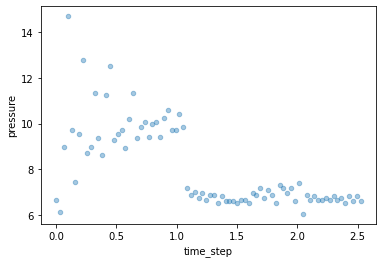

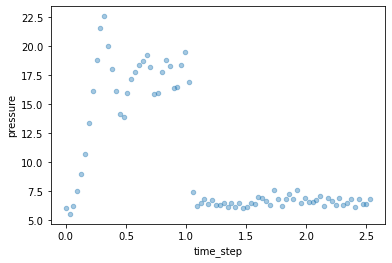

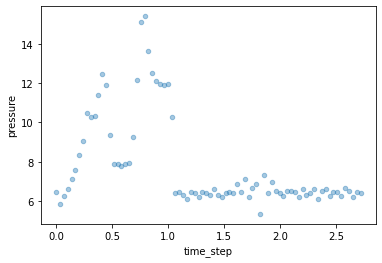

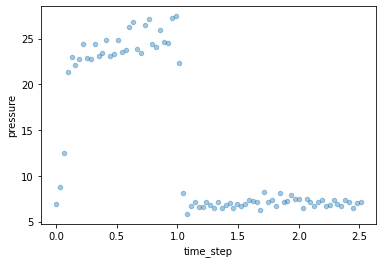

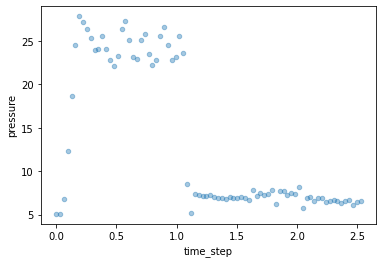

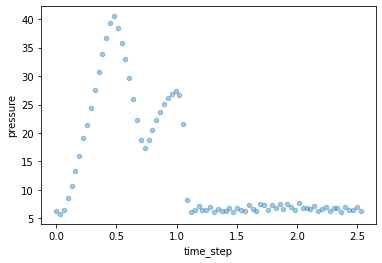

In [23]:
test1 = data[data['breath_id'] == 12]
test2 = data[data['breath_id'] == 27]

test3 = data[data['breath_id'] == 125740]
test4 = data[data['breath_id'] == 125745]

test5 = data[data['breath_id'] == 3]
test6 = data[data['breath_id'] == 4]

test1.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

test2.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

test3.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

test4.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

test5.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

test6.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

In [22]:
 data[data['R'] == 50]['breath_id'].unique()

array([     3,      4,      7, ..., 125740, 125745, 125749], dtype=int64)

<AxesSubplot:xlabel='time_step', ylabel='pressure'>

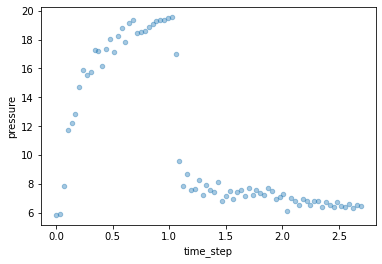

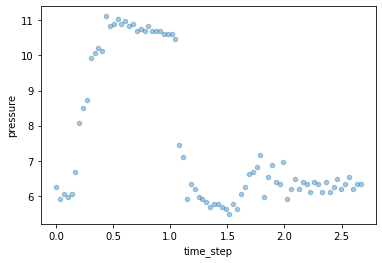

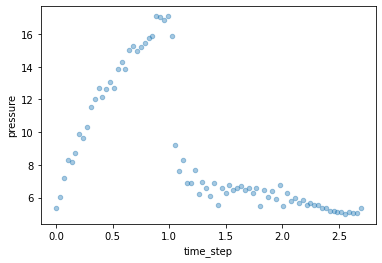

In [21]:
test1 = data[data['breath_id'] == 1]
test2 = data[data['breath_id'] == 125743]
test3 = data[data['breath_id'] == 9]

test1.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

test2.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

test3.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

In [20]:
added_features_data.shape

(3281120, 85)

In [36]:
data.shape

(2417200, 7)

In [44]:
prediction_rest

array([6.27907869, 5.9058075 , 7.05594718, ..., 6.26530918, 6.26301312,
       6.36459649])

In [45]:
added_features_data

,R,C,u_out,time_index,time_step_catagory,0,1,2,3,4,...,70,71,72,73,74,75,76,77,78,79
0,5,20,0,0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5,20,0,1,0.0,0.000000,7.515046,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5,20,0,2,0.0,0.000000,7.515046,14.651675,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5,20,0,3,0.0,0.000000,7.515046,14.651675,21.23061,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,20,0,4,0.0,0.000000,7.515046,14.651675,21.23061,26.320956,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2417195,20,10,1,75,1.0,9.985853,35.151391,0.000000,0.00000,14.323999,...,4.932934,4.943394,4.952134,4.959653,4.965959,4.971245,0.000000,0.000000,0.000000,0.000000
2417196,20,10,1,76,1.0,9.985853,35.151391,0.000000,0.00000,14.323999,...,4.932934,4.943394,4.952134,4.959653,4.965959,4.971245,4.975709,0.000000,0.000000,0.000000
2417197,20,10,1,77,1.0,9.985853,35.151391,0.000000,0.00000,14.323999,...,4.932934,4.943394,4.952134,4.959653,4.965959,4.971245,4.975709,4.979468,0.000000,0.000000
2417198,20,10,1,78,1.0,9.985853,35.151391,0.000000,0.00000,14.323999,...,4.932934,4.943394,4.952134,4.959653,4.965959,4.971245,4.975709,4.979468,4.982648,0.000000


In [63]:
data_train['pressure'] = prediction_rest

In [69]:
data_train['pressure'] = prediction

In [64]:
dataR50 = data_train

In [70]:
dataREAL50 = data_train

In [71]:
dataREAL50

,breath_id,R,C,time_step,u_in,u_out,time_index,pressure
160,11,50,10,0.000000,33.717608,0,0,3.619128
161,11,50,10,0.035074,26.595397,0,1,9.735002
162,11,50,10,0.069354,20.281570,0,2,14.371867
163,11,50,10,0.103556,13.548649,0,3,21.052173
164,11,50,10,0.138664,6.483971,0,4,22.684681
...,...,...,...,...,...,...,...,...
4023915,125747,50,10,2.582654,4.980081,1,75,6.520518
4023916,125747,50,10,2.617739,4.983286,1,76,6.520518
4023917,125747,50,10,2.651807,4.985904,1,77,6.520518
4023918,125747,50,10,2.686144,4.988127,1,78,6.520518


In [94]:
final = pd.concat([dataREAL50, dataR50], axis=0)

In [74]:
data = pd.read_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Data\ventilator-pressure-prediction\test.csv")

In [99]:
output

,id,pressure
1606800,0,6.279079
1606801,1,5.905807
1606802,2,7.055947
1606803,3,7.302555
1606804,4,8.633921
...,...,...
4023995,4023995,6.258171
4023996,4023996,6.281370
4023997,4023997,6.265309
4023998,4023998,6.263013


In [96]:
test = reset_final.rename(columns={"index":"id"})

In [98]:
output = test.sort_values("id")
output.drop(columns=['breath_id'], inplace=True)
output.drop(columns=['time_step'], inplace=True)
output.drop(columns=['u_in'], inplace=True)
output.drop(columns=['u_out'], inplace=True)
output.drop(columns=['R'], inplace=True)
output.drop(columns=['C'], inplace=True)
output.drop(columns=['time_index'], inplace=True)

In [104]:
output.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\submission_3.csv", index=False)

In [102]:
output['id'] = output['id'] + 1

In [103]:
output

,id,pressure
1606800,1,6.279079
1606801,2,5.905807
1606802,3,7.055947
1606803,4,7.302555
1606804,5,8.633921
...,...,...
4023995,4023996,6.258171
4023996,4023997,6.281370
4023997,4023998,6.265309
4023998,4023999,6.263013
